In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import cv2
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
datasetPath = '/content/gdrive/MyDrive/flowerClassification/flowers/'
os.listdir(datasetPath)

['rose', 'daisy', 'sunflower', 'tulip', 'dandelion']

In [ ]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [ ]:
data = get_data(datasetPath)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


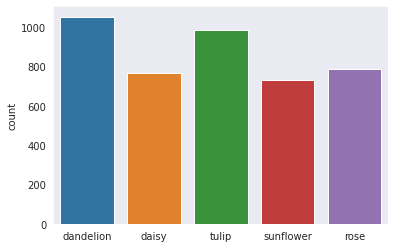

In [ ]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)
plt.show()

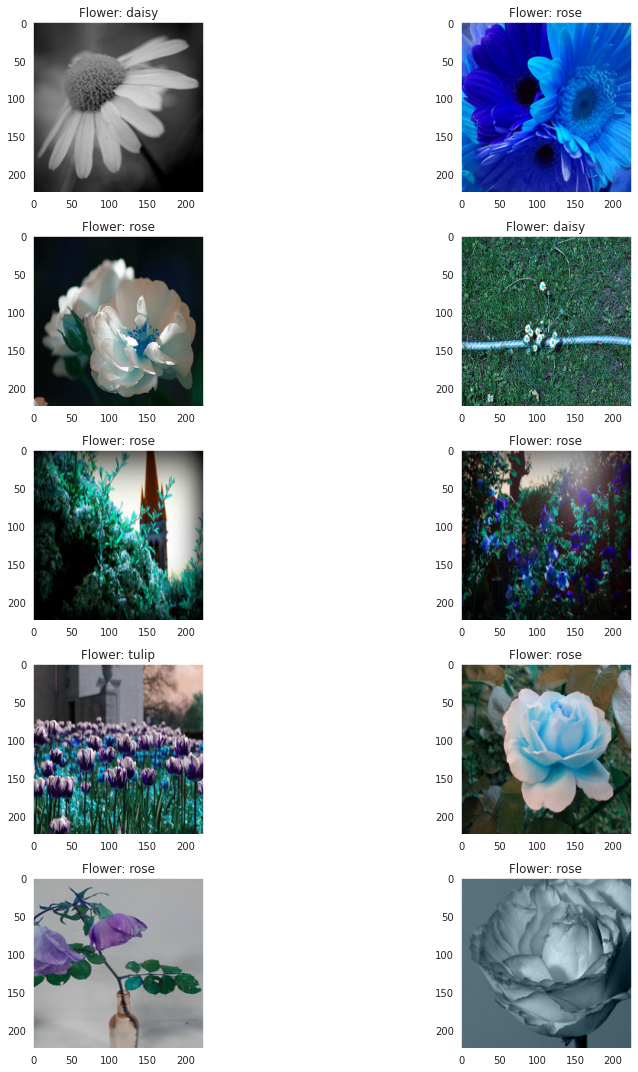

In [ ]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

In [ ]:
CLASS_NUM = 5
BATCH_SIZE = 64
EPOCH_STEPS = int(len(data)/BATCH_SIZE)
IMAGE_SHAPE = (224, 224, 3)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
generator_main = train_datagen.flow_from_directory(
    datasetPath,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 4317 images belonging to 5 classes.


In [ ]:
def my_generator(generator):
    while True:
        data = next(generator)
        x = data[0]
        y = data[1], data[1], data[1]
        yield x, y

train_generator = my_generator(generator_main)

In [ ]:
def inception(x, filters):
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)
    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [ ]:

def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer

In [ ]:
def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model

In [ ]:
model = googlenet()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
history_all = {}

print('Using optimizer: Adam  Epoch: 30')
    
model.compile(loss='categorical_crossentropy', 
              loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
              optimizer='adam', metrics=['accuracy'])

train_history = model.fit_generator(
        train_generator,
        steps_per_epoch=EPOCH_STEPS,
        epochs=30,
        shuffle=True
        )
    
for key in history_all:
    history_all[key].extend(train_history.history[key])


Using optimizer: Adam  Epoch: 30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/30
67/67 [==============================] - 96s 1s/step - loss: 2.2022 - main_loss: 1.3903 - aux1_loss: 1.3530 - aux2_loss: 1.3534 - main_accuracy: 0.3666 - aux1_accuracy: 0.4361 - aux2_accuracy: 0.3850
Epoch 2/30
67/67 [==============================] - 84s 1s/step - loss: 1.7253 - main_loss: 1.0905 - aux1_loss: 1.0417 - aux2_loss: 1.0745 - main_accuracy: 0.5375 - aux1_accuracy: 0.5765 - aux2_accuracy: 0.5608
Epoch 3/30
67/67 [==============================] - 85s 1s/step - loss: 1.5056 - main_loss: 0.9481 - aux1_loss: 0.9203 - aux2_loss: 0.9378 - main_accuracy: 0.6106 - aux1_accuracy: 0.6344 - aux2_accuracy: 0.6250
Epoch 4/30
67/67 [==============================] - 84s 1s/step - loss: 1.4652 - main_loss: 0.9306 - aux1_loss: 0.8780 - aux2_loss: 0.9038 - main_accuracy: 0.6219 - aux1_accuracy: 0.6567 - aux2_accuracy: 0.6501
Epoch 5/30
67/67 [==============================] - 84s 1s/step - loss: 1.3379 - main_loss: 0.8524 - aux1_loss: 0.8003 - aux2_loss: 0.8183 - main_accuracy: 

In [ ]:
def show_train_history(history, xlabel, ylabel, train):
    for item in train:
        plt.plot(history[item])
    plt.title('Train History')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

show_train_history(train_history.history, 'Epoch', 'Accuracy', ('main_accuracy', 'aux1_accuracy', 'aux2_accuracy'))
show_train_history(train_history.history, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'))

In [ ]:
testImage = cv2.imread("/content/gdrive/MyDrive/flowerClassification/flowers/dandelion/10200780773_c6051a7d71_n.jpg")

In [ ]:
image = cv2.resize(testImage, (224,224))

In [ ]:


plt.imshow(testImage)
plt.show()

In [ ]:
image = image / 255

In [ ]:
classes = model.predict(image.reshape(1,224,224,3))

In [ ]:
np.argmax(classes)

6

In [ ]:
generator_main.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [ ]:
for label, index in generator_main.class_indices.items():
  if index == np.argmax(classes):
      print("Predicted flower is", label)

In [ ]:
model.save("/content/gdrive/MyDrive/flowerClassification/flowerClassification.model")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ProjectDeliveries/flowerClassification/flowerClassification.model/assets


In [ ]:
path = "/content/gdrive/MyDrive/flowerClassification/flowers/dandelion/10200780773_c6051a7d71_n.jpg"

In [ ]:
LoadedModel = load_model("/content/gdrive/MyDrive/flowerClassification/flowerClassification.model")

In [ ]:
def prediction(path):
  labels = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
  testImage = cv2.imread(path)
  image = cv2.resize(testImage, (224,224))
  image = image / 255
  classes = LoadedModel.predict(image.reshape(1,224,224,3))
  for label, index in labels.items():
    if index == np.argmax(classes[1]):
       return label, np.max(classes[1])

In [ ]:
print(prediction(path))

('dandelion', 0.8198326)
